In [64]:
import torch
import torchvision

from torch import nn 
from torchvision import transforms
from tqdm import tqdm

In [65]:
if torch.cuda.is_available():
    device = torch.device("cuda")

In [66]:
# Pre-processing data
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [67]:
# Importing the weights for the trained model resnet50 (50 layers)
resnet50_model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)

# Excluding the last layer - (fc): Linear(in_features=2048, out_features=1000, bias=True)
resnet50_model.fc = nn.Identity()

# Send to device
resnet50_model = resnet50_model.to(device)

In [68]:
# Load weights from the 5 iteration model
fc_state_dict = torch.load("models/fc_model_3.pth", weights_only=True)

# Creating a fully-connected model
fc_model = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1)
).to(device)

# Set weights
fc_model.load_state_dict(fc_state_dict)

# Combining the two models
model = nn.Sequential(
    resnet50_model,
    fc_model
).to(device)

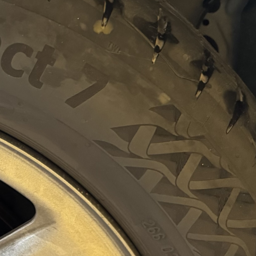

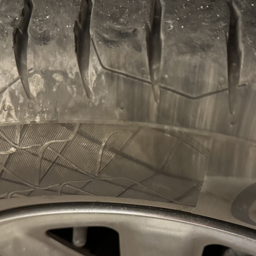

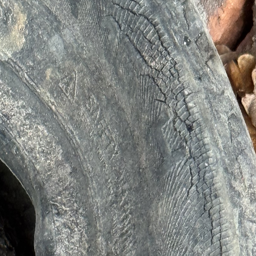

In [69]:
from PIL import Image
from IPython.display import display

# Display images
tires = []
for i in range(3):
    img = Image.open(f"./prediction/tire{i+1}.jpg")
    display(img.resize([256, 256]))
    tires.append(img)

In [70]:
# Pre-processing images and adding 1 dimension to each one
for i, tire in enumerate(tires):
    tire = preprocess(tire)
    tire = tire.unsqueeze(dim=0)
    tires[i] = tire

print(tires[0].shape)

torch.Size([1, 3, 224, 224])


In [71]:
model.eval()
with torch.no_grad():
    for i, tire in enumerate(tires):
        tire = tire.to(device)
        y_pred = torch.sigmoid(model(tire))

        if y_pred > 0.5:
            print(f"The tire {i} is good with a probability of {100*y_pred.item():.2f} %.")
        else:
            print(f"The tire {i} is defective with a probability of {100*(1-y_pred.item()):.2f} %.")

The tire 0 is good with a probability of 99.78 %.
The tire 1 is good with a probability of 98.06 %.
The tire 2 is defective with a probability of 99.96 %.
